# Hyper-parameter Tunning with Genetic Algorithm
### An Example on Tunning Hyper-Parameters for LSTM Time Series Forecasting

> Tianyu Du, Dec. 31, 2018

In this notebook, we will use `GeneticTuner` to generate hyper-parameter sets and find a HP set minimizes the MSE loss on validation set.

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

### Add the project home directory

In [3]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

### Load essential control packages.

In [4]:
import core.genetic.control as control
import core.genetic.tuner as tuner

### Load the LSTM RNN to train.

In [5]:
import core.models.stacked_lstm as stacked_lstm

### Configuration.
### i) Dataset
Use *absolute* path instead of a relative one.

In [6]:
FILE_DIR = "/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv"

### ii) The Initial Genetic Pool
* **Fixed Genetic Bits**: Use a *single value* to represent a fixed gene bit, each individual in the <u>initial population</u> will have the same gene on those bits.

* **Flexiable Genetic Bits**: Use a *list* to represent a flexiable gene bit, each indivudal in the <u>initial population</u> takes a random element from that list as their own gene value at that bit.

In [15]:
GENE_POOL = {
    # ======== Data Pre-processing Parameter ========
    "PERIODS": 1,
    "ORDER": 1,
    "LAGS": [3, 6],
    "TRAIN_RATIO": 0.8,
    "VAL_RATIO": 0.1,
    # ======== Model Training Parameter ========
    "epochs": [3, 4, 5],
    "num_inputs": 1,
    "num_outputs": 1,
    "num_time_steps": None,  # num_time_steps is identical to LAGS
    "num_neurons": [
        [16, 32],
        [32, 64],
        [16, 16, 32],
        [16, 16, 32, 32]
    ],
    "learning_rate": [
        0.1,
        0.03,
        0.01
    ],
    "clip_grad": None,
    "report_periods": 10
}


### iii) Evoluation
* `TOTAL_GEN`: The total number of generations to evolve.
* `POP_SIZE`: After the selection and breeding phases in each round of evolving, the population size will be mained to this size.
* `RETAIN`: The proportion of population to be retained after selection.
* `SHOT_PROB`: The probability that one individual not selected based on its fittness score to be retained to the next generation.
* `MUTATE_PROB`: The probability to be mutated.
* `IGNORE_SET`: The set of genetic bits to be skipped during mutation and cross-over phases.

In [16]:
# Training Spec.
TOTAL_GEN = 3
POP_SIZE = 10
RETAIN = 0.5
SHOT_PROB = 0.1
MUTATE_PROB = 0.05
IGNORE_SET = (
    "PERIODS", "ORDER", "TRAIN_RATIO", "VAL_RATIO", "num_outputs", "num_inputs", "report_periods"
)

In [17]:
def eval_net_wrapper(param):
    return control.eval_net(
        model=stacked_lstm.StackedLSTM,
        param=param,
        file_dir=FILE_DIR,
        metric="mse_val",
        smooth_metric=0.05
    )

In [18]:
# Create the Optimizer.
optimizer = tuner.GeneticTuner(
    gene_pool=GENE_POOL,
    pop_size=POP_SIZE,
    eval_func=eval_net_wrapper,
    mode="min",
    retain=RETAIN,
    shot_prob=SHOT_PROB,
    mutate_prob=MUTATE_PROB,
    verbose=False,
    ignore=IGNORE_SET
)

### Specify the directory to save elite chromosomes (parameter sets).

In [21]:
save = "/Users/tianyudu/Downloads/gen"

In [19]:
start_time = datetime.datetime.now()

In [20]:
elite = control.train_op(
    optimizer=optimizer,
    total_gen=TOTAL_GEN,
    elite=0.5,
    write_to_disk=None
)

Generation: [0/3]
Evaluating the initial population.
 ########## Evaluating... [10/10, 100.00%] Current Net: size=[16, 16, 32], ep=3, lr= 0.0100100
Best fitted entity validatiton MSE:  0.0256997        
Worst fitted entity validation MSE:  0.5187203
Generation: [1/3]
 ########### Evaluating... [11/11, 100.00%] Current Net: size=[23, 49], ep=3, lr= 0.0183
Best fitted entity validatiton MSE:  0.0323585        
Worst fitted entity validation MSE:  0.3477542
Folder /Users/tianyudu/Downloads/gen/gen0/occupied, directly write to it.
Time taken: 0:00:15.551538
Generation: [2/3]
 ########## Evaluating... [10/10, 100.00%] Current Net: size=[18, 32], ep=4, lr= 0.0288
Best fitted entity validatiton MSE:  0.0385235        
Worst fitted entity validation MSE:  0.4607473
Folder /Users/tianyudu/Downloads/gen/gen1/occupied, directly write to it.
Time taken: 0:00:13.768377
Generation: [3/3]
 ########## Evaluating... [10/10, 100.00%] Current Net: size=[20, 40], ep=4, lr= 0.0220
Best fitted entity valida

In [22]:
end_time = datetime.datetime.now()
print(f"Time taken: {end_time - start_time}")

Time taken: 0:02:06.427207


### The Result.
#### The best performed individual in the last generation.

In [30]:
(best, score) = list(elite.values())[-1][0]
pprint(best)
print("Validation Set MSE: " + str(score))

{'LAGS': 3,
 'ORDER': 1,
 'PERIODS': 1,
 'TRAIN_RATIO': 0.8,
 'VAL_RATIO': 0.1,
 'clip_grad': None,
 'epochs': 4,
 'learning_rate': 0.01918072367906084,
 'num_inputs': 1,
 'num_neurons': [21, 39],
 'num_outputs': 1,
 'num_time_steps': 3,
 'report_periods': 10}
Validation Set MSE: 0.04385799542069435


### Visualize the Progress
#### We can plot the statistics on elite group in each generation.

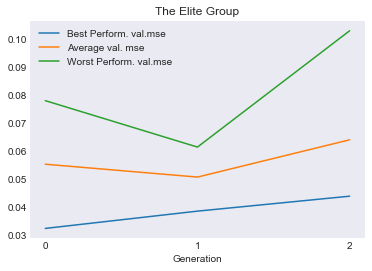

In [33]:
plt.close()
plt.style.use('seaborn-dark')
plt.title("The Elite Group")
plt.plot([
    elite_gp[0][1] 
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    np.mean([x[1] for x in elite_gp])
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    elite_gp[-1][1] 
    for elite_gp in list(elite.values())]
)
plt.legend(
    ["Best Perform. val.mse", "Average val. mse", "Worst Perform. val.mse"],
    loc="best"
)

plt.xlabel("Generation")
plt.xticks(range(TOTAL_GEN))

plt.show()